# Bayesian logistic regression:

In [36]:
import jax.numpy as jnp
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from coinem.model import AbstractModel
from coinem.dataset import Dataset

# Model

Consider two variants of the logistic regression model considered by Liu and Wang (2016). One where the parameters of the Gamma distribution on the prior of $\alpha$ are fixed, and the other where we learn them.

In [37]:
from jaxtyping import Array, Float, PyTree
import tensorflow_probability.substrates.jax.distributions as tfd
from jax.scipy import optimize

@dataclass
class LogisticRegressionLearnTheta(AbstractModel):
    """Base class for p(θ, x)."""
    num_datapoints: int
    
    def log_prob(self, latent: Float[Array, "D 1"], theta: Float[Array, "Q"], batch: Dataset) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (Q,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """
        alpha = jnp.exp(latent["alpha"])
        beta = latent["beta"]
        a0 = jnp.exp(theta["a0"])
        b0 = jnp.exp(theta["b0"])


        # likelihood
        z = jnp.matmul(batch.X, beta)
        log_lik = tfd.Bernoulli(logits=z.squeeze()).log_prob(batch.y.squeeze()).sum()
        

        # Compute linear predictor.
        z = jnp.matmul(batch.X, beta)

        # Prior
        log_prior = tfd.Normal(loc=0.0, scale=1.0/jnp.sqrt(alpha)).log_prob(beta).sum().squeeze()
        log_prior_alpha = tfd.Gamma(a0, rate=b0).log_prob(alpha).sum().squeeze()


        # Compute log-probability.
        return (log_lik * self.num_datapoints / batch.n + log_prior + log_prior_alpha).squeeze()
    
    def optimal_theta(self, latent_particles: PyTree[Float[Array, "N D *"]]) -> PyTree[Float[Array, "Q *"]]:
        samples = jnp.exp(latent_particles["alpha"])

        def gamma_pdf(log_a):
            a = jnp.exp(log_a)
            b = a/samples.mean()
            return -tfd.Gamma(a, b).log_prob(samples).sum()


        log_a_estimate, *_ = optimize.minimize(gamma_pdf, jnp.array([1.0]), method='BFGS')
        log_b_estimte = log_a_estimate - jnp.log(samples.mean())

        return {"a0": log_a_estimate.squeeze(), "b0": log_b_estimte.squeeze()}
    

@dataclass
class LogisticRegressionFixedTheta(AbstractModel):
    """Base class for p(θ, x)."""
    num_datapoints: int
    
    def log_prob(self, latent: Float[Array, "D 1"], theta: Float[Array, "Q"], batch: Dataset) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (Q,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """
        alpha = jnp.exp(latent["alpha"])
        beta = latent["beta"]


        # likelihood
        z = jnp.matmul(batch.X, beta)
        log_lik = tfd.Bernoulli(logits=z.squeeze()).log_prob(batch.y.squeeze()).sum()
        

        # Compute linear predictor.
        z = jnp.matmul(batch.X, beta)

        # Prior
        log_prior = tfd.Normal(loc=0.0, scale=1.0/jnp.sqrt(alpha)).log_prob(beta).sum().squeeze()
        log_prior_alpha = tfd.Gamma(concentration=1.0, rate=0.01).log_prob(alpha).sum().squeeze()


        # Compute log-probability.
        return (log_lik * self.num_datapoints / batch.n  + log_prior + log_prior_alpha).squeeze()
    

# Train the models on covertype

In [38]:
import scipy 
import numpy as np
from sklearn.model_selection import train_test_split

data = scipy.io.loadmat('data/covertype.mat')
    
X_input = data['covtype'][:, 1:]
y_input = data['covtype'][:, 0]
y_input[y_input == 2] = 0

N = X_input.shape[0]
X_input = np.hstack([X_input, np.ones([N, 1])])

# split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=42)

train_data = Dataset(jnp.array(X_train), jnp.array(y_train).reshape(-1, 1))

In [39]:
from coinem.zoo import coin_svgd
from coinem.marginal_zoo import marginal_coin_svgd
from jax import vmap
import jax.random as jr
import jax.tree_util as jtu

# Set approximation parameters:
K = 1000  # Number of steps.
N = 100  # number of particles.

# 😈 Rough numpy code for initialization
np.random.seed(42)
dim = X_train.shape[-1]
a0 = 1.0
b0 = 0.01
beta0 = np.zeros([N, dim])
alpha0 = np.random.gamma(a0, b0, N).reshape(-1, 1)
for i in range(N):
    beta0[i, :] = np.random.normal(0, np.sqrt(1 / alpha0[i]), dim)
# 😈 

# Create initial state:
th0 = {"a0": jnp.log(a0), "b0": jnp.log(b0)}
X0 = {"alpha": jnp.array(alpha0), "beta": jnp.array(beta0)}

fixed_theta = LogisticRegressionFixedTheta(train_data.n)
learn_theta = LogisticRegressionLearnTheta(train_data.n)


# Run SVGD:
x_coin_fixed, theta_coin_fixed = coin_svgd(fixed_theta, train_data, X0, th0, K, batch_size=100)
x_coin_learn, theta_coin_learn = coin_svgd(learn_theta, train_data, X0, th0, K, batch_size=100)

x_coin_learn_marginal, theta_coin_learn_marginal = marginal_coin_svgd(learn_theta, train_data, X0, th0, K, batch_size=100)

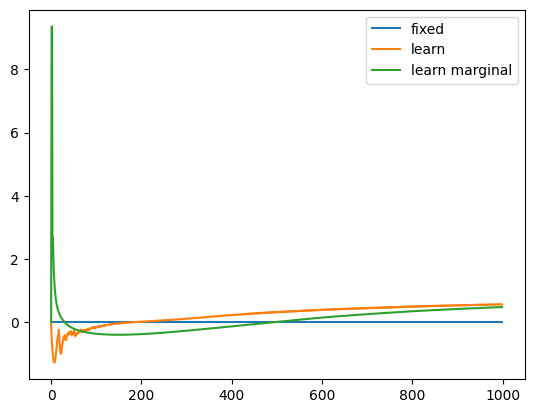

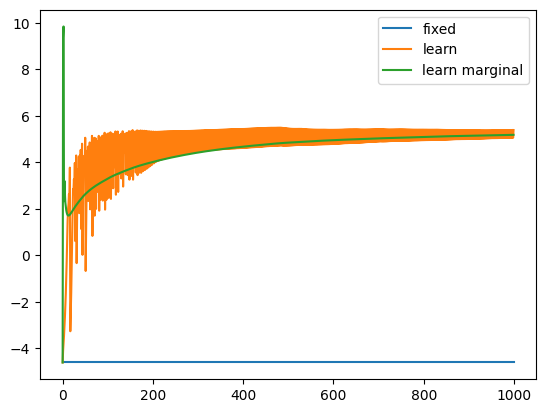

In [40]:
plt.plot(theta_coin_fixed["a0"], label="fixed")
plt.plot(theta_coin_learn["a0"], label="learn")
plt.plot(theta_coin_learn_marginal["a0"], label="learn marginal")
plt.legend()
plt.show()

plt.plot(theta_coin_fixed["b0"], label="fixed")
plt.plot(theta_coin_learn["b0"], label="learn")
plt.plot(theta_coin_learn_marginal["b0"], label="learn marginal")
plt.legend()
plt.show()

In [41]:
# Compute AUC:
from sklearn.metrics import roc_auc_score

def predict_prob(test_inputs, latent):
    """Returns label maximizing the approximate posterior predictive 
    distribution defined by the cloud X, vectorized over feature vectors f.
    """
    s = vmap(lambda x: tfd.Bernoulli(logits=jnp.matmul(test_inputs, x)).mean())(latent).mean(0)
    return s

coin_fixed_auc = roc_auc_score(y_test, predict_prob(X_test, x_coin_fixed["beta"][-1]))
coin_learn_auc = roc_auc_score(y_test, predict_prob(X_test, x_coin_learn["beta"][-1]))

x_coin_learn_marginal_auc = roc_auc_score(y_test, predict_prob(X_test, x_coin_learn_marginal["beta"][-1]))

print(f"Coin Fixed AUC: {coin_fixed_auc}")
print(f"Coin Learn AUC: {coin_learn_auc}")
print(f"Coin Learn Marginal AUC: {x_coin_learn_marginal_auc}")

Coin Fixed AUC: 0.8136471156116583
Coin Learn AUC: 0.8140640051736924
Coin Learn Marginal AUC: 0.8137289199531783
